## Import

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
import seaborn as sns
sns.set(
    style="ticks",
    font="DejaVu Sans",
    rc={
        # Typography
        "font.size": 10,          
        "axes.titlesize": 16,     
        "axes.titleweight": "bold",
        "axes.labelsize": 14,      
        "xtick.labelsize": 12,     
        "ytick.labelsize": 12,
        "legend.fontsize": 10,
        
        # Spines and Ticks
        "axes.spines.top": False,    
        "axes.spines.right": False,  
        "axes.linewidth": 0.8,      
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out", 
        "ytick.direction": "out",
    }
)
color_palette = ['#009E73', '#0072B2', '#D55E00']
sns.set_palette(color_palette)
#sns.set_context(
#    "notebook", rc={"font.size": 12, "axes.titlesize": 16, "axes.labelsize": 12}
#)

## Analysis 1: Weight function and Contributions to the Dataset Index

In [25]:
# Function
def calculate_time_weight(delta_t, k=0.33):
    """
    Calculates the logarithmic time weight for a citation or mention.
    delta_t: Years between dataset publication and the citation/mention event.
    """
    return 1 + k * np.log(1 + max(0, delta_t))

In [26]:
# Data
delta_t_range = np.linspace(0, 100, 101) 
weights = []
for dt in delta_t_range:
    weights.append(calculate_time_weight(dt))

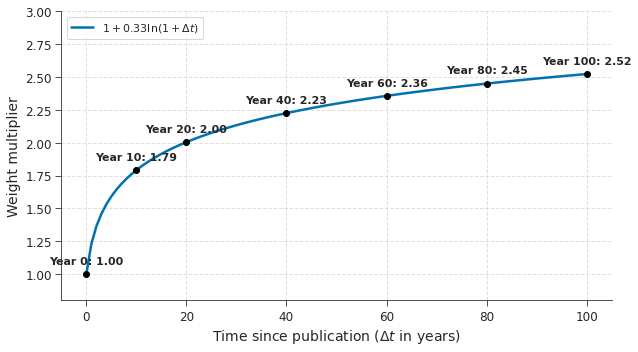

In [27]:
# Layout
fig, ax = plt.subplots(figsize=(9, 5))

#Plot
ax.plot(delta_t_range, weights, label=r'$1 + 0.33 \ln(1 + \Delta t)$', color=color_palette[1], linewidth=2.5)

## Highlight specific anchor points
t_points = np.array([0, 10, 20, 40, 60, 80, 100])
w_points = []
for dt in t_points:
    w_points.append(calculate_time_weight(dt))
ax.scatter(t_points, w_points, color='black', zorder=5)

for i in range(len(t_points)):
    txt = f'Year {t_points[i]}: {w_points[i]:.2f}'
    ax.annotate(txt, (t_points[i], w_points[i]), textcoords="offset points", 
                        xytext=(0, 10), ha='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Time since publication ($\Delta t$ in years)')
ax.set_ylabel('Weight multiplier')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(0.8, 3)
ax.legend(loc='upper left', fontsize=11)
#ax.set_title('Time weighted function to reward sustained reuse (citations and mentions)', pad=15, fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('output/Analysis1.png', dpi=300, format='png')
plt.show()

## Analysis 2: Contributions to the Dataset Index

In [28]:
# Functions
def get_dataset_index(fi, citation_deltas, mention_deltas, ft=50, ctw=1, mtw=1):
    """
    Calculates the dataset index (Di) based on FAIR score and 
    weighted impact over time of citations and mentions.
    """
    # FAIR term (Normalized)
    term_f = fi / ft
    
    # Weighted citations term
    ciw = sum(calculate_time_weight(dt) for dt in citation_deltas)
    term_c = ciw / ctw
    
    # Weighted mentions term
    miw = sum(calculate_time_weight(dt) for dt in mention_deltas)
    term_m = miw / mtw
    
    # Calculate components weighted by 1/3 for the average
    f_comp = (1/3) * term_f
    c_comp = (1/3) * term_c
    m_comp = (1/3) * term_m
    
    di = f_comp + c_comp + m_comp
    
    return di, f_comp, c_comp, m_comp, ciw, miw

def get_researcher_s_index(dataset_indices):
    """
    Calculates the S-index as the sum of all Dataset Indices.
    """
    return sum(dataset_indices)

In [29]:
# Simulation parameters
fi, ft, ctw, mtw = 50, 50, 2, 2
years = np.arange(0, 21)
history_years = []
results = []

# Data
for t in years:
    if t > 0:
        history_years.append(t) 
    
    citation_event_times = [r for r in history_years]
    mention_event_times = citation_event_times
    di, f_val, c_val, m_val, ciw, miw = get_dataset_index(fi, citation_event_times, mention_event_times, ft, ctw, mtw)
    
    results.append({
        'Year': t,
        'Di': di,
        'F_val': f_val, 'C_val': c_val, 'M_val': m_val,
        'F_pct': (f_val / di) * 100,
        'C_pct': (c_val / di) * 100,
        'M_pct': (m_val / di) * 100,
        'ciw': ciw,
        'miw': miw,
    })

df = pd.DataFrame(results)

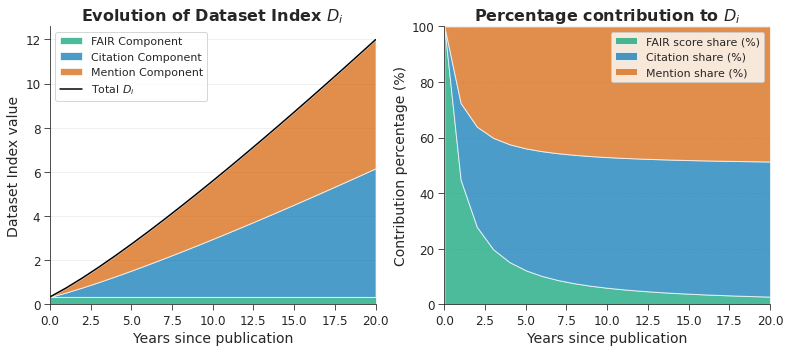

In [30]:
# Plot
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(11, 5))


# Left: Dataset Index growth
ax_left.stackplot(df['Year'], df['F_val'], df['C_val'], df['M_val'], 
                             labels=['FAIR Component', 'Citation Component', 'Mention Component'],
                             alpha=0.7)
ax_left.plot(df['Year'], df['Di'], color='black', linewidth=1.5, label='Total $D_i$')
ax_left.set_title('Evolution of Dataset Index $D_i$', fontweight='bold')
ax_left.set_xlabel('Years since publication')
ax_left.set_ylabel('Dataset Index value')
ax_left.legend(loc='upper left', fontsize=11)
ax_left.grid(axis='y', alpha=0.3)
ax_left.set_xlim(0, 20)


# Right: Percentage contribution of each factor
ax_right.stackplot(df['Year'], df['F_pct'], df['C_pct'], df['M_pct'], 
                              labels=['FAIR score share (%)', 'Citation share (%)', 'Mention share (%)'],
                              alpha=0.7)
ax_right.set_title('Percentage contribution to $D_i$', fontweight='bold')
ax_right.set_xlabel('Years since publication')
ax_right.set_ylabel('Contribution percentage (%)')
ax_right.set_ylim(0, 100)
ax_right.set_xlim(0, 20)
ax_right.legend(loc='upper right', fontsize=11)
ax_right.grid(axis='y', linestyle='--', alpha=0.3)

# Save
plt.tight_layout()
plt.savefig('output/Analysis2.png', dpi=300, format='png')
plt.show()

## Analysis 3: Importance of field-specific normalization factors

In [31]:
# Functions
def get_di_normalized(fi, ciw, miw, ft, ctw, mtw):
    return (1/3) * (fi/ft + ciw/ctw + miw/mtw)

def get_di_raw(fi, ciw, miw):
    return (1/3) * (fi + ciw + miw)

In [32]:
# Simulation parameters for two researchers 5 datasets each
## Researcher A (Emerging field): Lower fair score, citations, mentions
## Researcher B (Established field): higher fair score, citations, mentions
data_A = {'Fi': [50, 45, 60, 40, 55], 'Ciw': [5, 4, 8, 3, 6], 'Miw': [3, 2, 4, 2, 3],
          'FT': 30, 'CTW': 2, 'MTW': 1}

data_B = {'Fi': [60, 65, 65, 70, 60], 'Ciw': [8, 9, 5, 9, 9], 'Miw': [8, 9, 5, 9, 9],
          'FT': 75, 'CTW': 20, 'MTW': 10}

# S-index Calculations
s_norm_A = sum(get_di_normalized(f, c, m, 30, 2, 1) for f, c, m in zip(data_A['Fi'], data_A['Ciw'], data_A['Miw']))
s_norm_B = sum(get_di_normalized(f, c, m, 75, 30, 10) for f, c, m in zip(data_B['Fi'], data_B['Ciw'], data_B['Miw']))

s_raw_A = sum(get_di_raw(f, c, m) for f, c, m in zip(data_A['Fi'], data_A['Ciw'], data_A['Miw']))
s_raw_B = sum(get_di_raw(f, c, m) for f, c, m in zip(data_B['Fi'], data_B['Ciw'], data_B['Miw']))

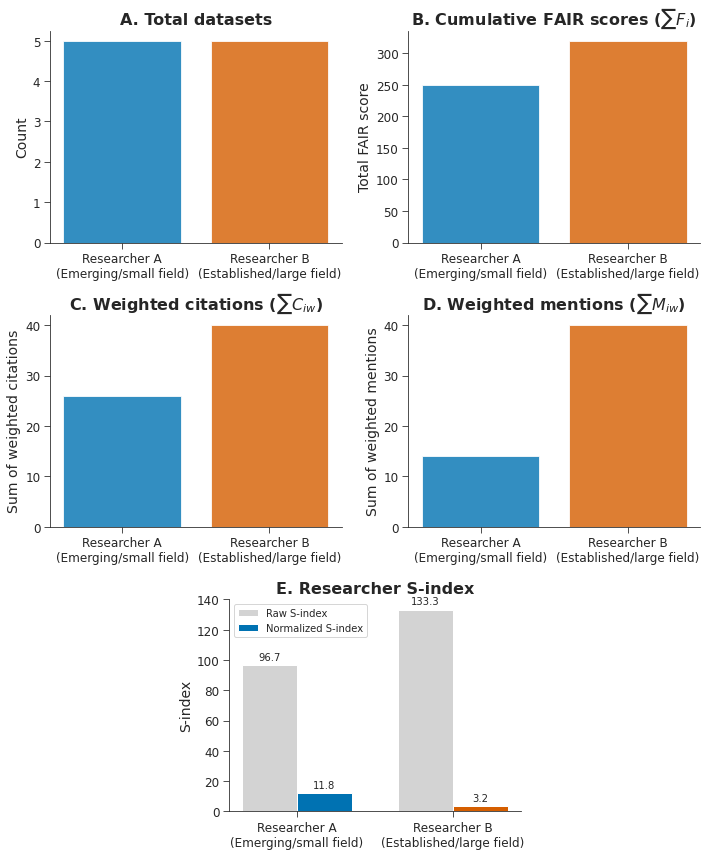

In [33]:
# Plots
layout = [['count', 'count', 'fair', 'fair'],
          ['citations', 'citations', 'mentions', 'mentions'],
          ['.', 'normalization', 'normalization', '.']]

fig, axd = plt.subplot_mosaic(layout, figsize=(10, 12))

# Extract colors from your accessible palette
palette = sns.color_palette()
color_a, color_b = palette[1], palette[2]
colors = [color_a, color_b]
researchers = ['Researcher A\n(Emerging/small field)', 'Researcher B\n(Established/large field)']

x = np.arange(len(researchers))
width = 0.35

# Plot 1: Number of datasets
axd['count'].bar(researchers, [len(data_A['Fi']), len(data_B['Fi'])], color=colors, alpha=0.8)
axd['count'].set_title('A. Total datasets', fontweight='bold')
axd['count'].set_ylabel('Count')

# Plot 2: Sum of FAIR scores
axd['fair'].bar(researchers, [sum(data_A['Fi']), sum(data_B['Fi'])], color=colors, alpha=0.8)
axd['fair'].set_title('B. Cumulative FAIR scores ($\sum F_i$)', fontweight='bold')
axd['fair'].set_ylabel('Total FAIR score')

# Plot 3: Sum of weighted citations
axd['citations'].bar(researchers, [sum(data_A['Ciw']), sum(data_B['Ciw'])], color=colors, alpha=0.8)
axd['citations'].set_title('C. Weighted citations ($\sum C_{iw}$)', fontweight='bold')
axd['citations'].set_ylabel('Sum of weighted citations')

# Plot 4: Sum of weighted mentions
axd['mentions'].bar(researchers, [sum(data_A['Miw']), sum(data_B['Miw'])], color=colors, alpha=0.8)
axd['mentions'].set_title('D. Weighted mentions ($\sum M_{iw}$)', fontweight='bold')
axd['mentions'].set_ylabel('Sum of weighted mentions')

# Plot 5: S-index (Raw vs Normalized)
rects3= axd['normalization'].bar(x - width/2, [s_raw_A, s_raw_B], width, label='Raw S-index', color='lightgrey')
rects4 = axd['normalization'].bar(x + width/2, [s_norm_A, s_norm_B], width, label='Normalized S-index', color=colors)
axd['normalization'].bar_label(rects3, padding=3, fmt='%.1f', fontsize=10)
axd['normalization'].bar_label(rects4, padding=3, fmt='%.1f', fontsize=10)
axd['normalization'].set_title('E. Researcher S-index', fontweight='bold')
axd['normalization'].set_xticks(x)
axd['normalization'].set_xticklabels(researchers)
axd['normalization'].set_ylabel('S-index')
axd['normalization'].legend(frameon=True, fontsize=10)

# Save
plt.tight_layout()
plt.savefig('output/Analysis3.png', dpi=300, format='png')
plt.show()

## Analysis 4: Average Dataset Index as a tool against index hacking

In [34]:
# Function
def get_di(fi, ciw, miw, ft=70, ctw=5, mtw=3):
    return (1/3) * (fi/ft + ciw/ctw + miw/mtw)

In [35]:
# Simulation parameters for two researchers from the same field one with 2 high impact datasets and one with many low impact datasets
## Field normalization factors
ft=70
ctw=5
mtw=3
    
# Steward: 2 very high impact datasets
data_A = {
    'Fi': [95, 90], 
    'Ciw': [15, 10], 
    'Miw': [6, 9]
}

# Factory: 15 datasets that are just below field medians
data_B = {
    'Fi': [50]*15, 
    'Ciw': [2]*15, 
    'Miw': [1]*15
}

# 3. Calculations
di_A = [get_di(f, c, m) for f, c, m in zip(data_A['Fi'], data_A['Ciw'], data_A['Miw'])]
di_B = [get_di(f, c, m) for f, c, m in zip(data_B['Fi'], data_B['Ciw'], data_B['Miw'])]

s_index_A, avg_di_A = sum(di_A), sum(di_A)/len(di_A)
s_index_B, avg_di_B = sum(di_B), sum(di_B)/len(di_B)

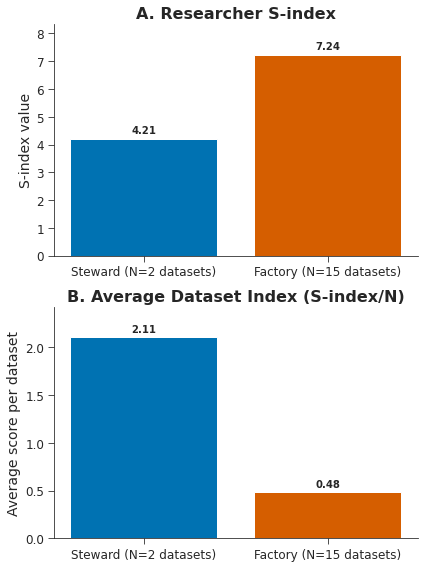

In [36]:
# Plots    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
palette = sns.color_palette()
color_a, color_b = palette[1], palette[2]
colors = [color_a, color_b]

bars1 = ax1.bar(['Steward (N=2 datasets)', 'Factory (N=15 datasets)'], [s_index_A, s_index_B], color=colors)
ax1.bar_label(bars1, padding=3, fmt='%.2f', fontweight='bold')
ax1.set_title(r'A. Researcher S-index', fontweight='bold')
ax1.set_ylabel('S-index value')
ax1.set_ylim(0, max(s_index_A, s_index_B) * 1.15)

# Plot 2: Average Dataset Index
bars2 = ax2.bar(['Steward (N=2 datasets)', 'Factory (N=15 datasets)'], [avg_di_A, avg_di_B], color=colors)
ax2.bar_label(bars2, padding=3, fmt='%.2f', fontweight='bold')
ax2.set_title(r'B. Average Dataset Index (S-index/N)', fontweight='bold')
ax2.set_ylabel('Average score per dataset')
ax2.set_ylim(0, max(avg_di_A, avg_di_B) * 1.15) 

# Save
plt.tight_layout()
plt.savefig('output/Analysis4.png', dpi=300, format='png')
plt.show()